In [ ]:
import snapatac2 as snap
import os
import sys
import scanpy as sc
import pandas as pd 
import Py_mTCall_tools.variant_calling
import importlib



In [ ]:
data = snap.pp.import_fragments(
    "fragments.tsv",
    chrom_sizes=snap.genome.hg38,
    file="sample1.h5ad",  # Optional
    sorted_by_barcode=False,
)
data

AnnData object with n_obs x n_vars = 5758 x 0 backed at 'imogen-sample1.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

2025-06-19 12:17:36 - INFO - Computing fragment size distribution...


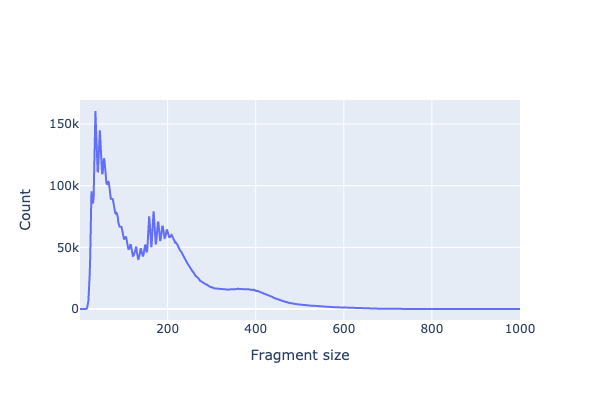

In [4]:
## Bit of extra information:
'''
1. Nucleosome-Free Region (NFR): The majority of fragments are short, typically around 80-300 base pairs (bp) in length. 
These short fragments represent regions of open chromatin where DNA is relatively accessible and not bound to nucleosomes. 
These regions are often referred to as nucleosome-free regions (NFRs) and correspond to regions of active transcriptional 
regulation.

2. Mono-Nucleosome Peaks: There is often a peak in the fragment size distribution at around 147-200 bp, 
which corresponds to the size of a single nucleosome wrapped DNA. These fragments result from the 
cutting of DNA by the transposase enzyme when it encounters a nucleosome, 
causing the DNA to be protected and resulting in fragments of the same size.

3. Di-Nucleosome Peaks: In addition to the mono-nucleosome peak, you may also observe 
a smaller peak at approximately 300-400 bp, corresponding to di-nucleosome fragments. 
These fragments occur when transposase cuts the DNA between two neighboring nucleosomes.

4. Large Fragments: Some larger fragments, greater than 500 bp in size, may be observed. 
These fragments can result from various sources, such as the presence of 
longer stretches of open chromatin or technical artifacts.
'''



snap.pl.frag_size_distr(data, interactive=False)

In [5]:
## Same plot with axis to log scale
fig = snap.pl.frag_size_distr(data, show=False)
fig.update_yaxes(type="log")
fig.show()

In [6]:
## TSS enrichment implies there is an increased accessibility or fragmentation of chromatin around the TSS
## Often indicative of promoter regions
snap.metrics.tsse(data, snap.genome.hg38)

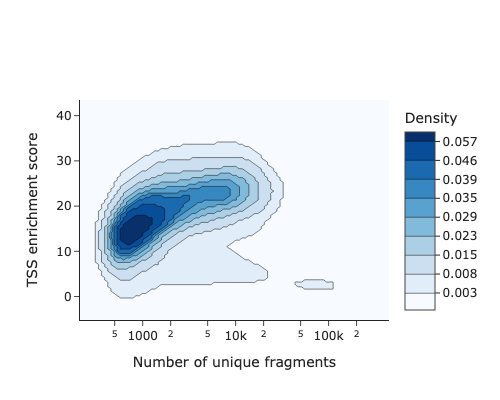

In [7]:
## To identify usable/high-quality cells, we can plot TSSe scores against number of unique fragments for each cell.
snap.pl.tsse(data, interactive=False)

##The cells in the upper right represent valid or high-quality cells, whereas those in the lower left represent low-quality 
# cells or empty droplets. Based on this plot, 
#we decided to set a minimum TSS enrichment of 10 and a minimum number of fragments of 5,000 to filter the cells.

In [8]:
snap.pp.filter_cells(data, min_counts=1000, min_tsse=10, max_counts=100000)
data

AnnData object with n_obs x n_vars = 2348 x 0 backed at 'imogen-sample1.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'frag_size_distr', 'reference_sequences', 'frac_overlap_TSS', 'TSS_profile', 'library_tsse'
    obsm: 'fragment_paired'

In [9]:
## Cell by bin matrix containng insertion counts across 500bp bins across the genome
snap.pp.add_tile_matrix(data)

In [10]:
## Feature selection, which will be stored in data.var['selected'] this is particularly relevant for scrublet and spectral
## Selects most accessible features 
## n_features determines number of features, experiment with n_features to find the optimal number for your dataset
snap.pp.select_features(data, n_features=250000)

2025-06-19 13:30:55 - INFO - Selected 250000 features.


In [11]:
## Scrublet is used to remove potential dublets. It will assign probabilities to each cell, and then we can filter
snap.pp.scrublet(data)
snap.pp.filter_doublets(data)
data

2025-06-19 13:31:05 - INFO - Simulating doublets...
2025-06-19 13:31:06 - INFO - Spectral embedding ...
2025-06-19 13:31:19 - INFO - Calculating doublet scores...
2025-06-19 13:31:21 - INFO - Detected doublet rate = 0.724%


AnnData object with n_obs x n_vars = 2331 x 6062095 backed at 'imogen-sample1.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'frag_size_distr', 'reference_sequences', 'frac_overlap_TSS', 'TSS_profile', 'library_tsse', 'scrublet_sim_doublet_score', 'doublet_rate'
    obsm: 'fragment_paired'

In [12]:
## Spectral embedding is used for dimensionality reduction
## Stored in data.obsm['X_spectral']
snap.tl.spectral(data)
snap.tl.umap(data)

/Users/nlt112/Library/CloudStorage/OneDrive-Personal/Documents/Work/Pickett/ATAC-Seq/snapATAC/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

/Users/nlt112/Library/CloudStorage/OneDrive-Personal/Documents/Work/Pickett/ATAC-Seq/snapATAC/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/nlt112/Library/CloudStorage/OneDrive-Personal/Documents/Work/Pickett/ATAC-Seq/snapATAC/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [15]:
## Perform graph based clustering, build k-nearest neighbour graph then use leiden algorithm to identify clusters
snap.pp.knn(data)
snap.tl.leiden(data, resolution=1.2)  # Adjust resolution for more or fewer clusters

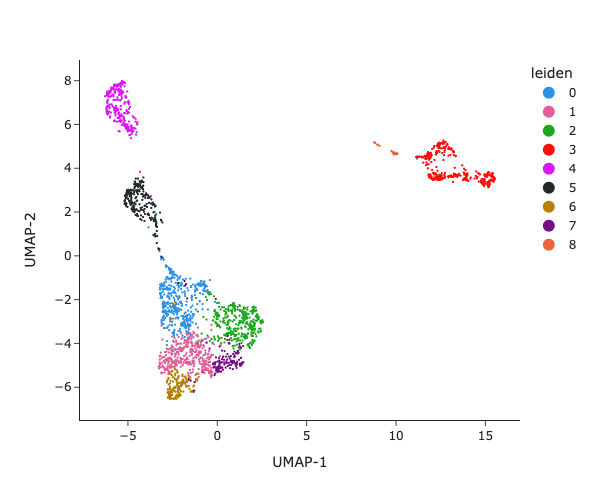

In [16]:
snap.pl.umap(data, color='leiden', interactive=False, height=500)

In [17]:
## Annotate the clusters and assign them to known cell types
## Compute gene activities for each cell using pp.make_gene_matrix

gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.hg38)
gene_matrix

/Users/nlt112/Library/CloudStorage/OneDrive-Personal/Documents/Work/Pickett/ATAC-Seq/snapATAC/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



AnnData object with n_obs × n_vars = 2331 × 60606
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'

In [18]:
### The cell by gene activity matrix is sparse
## The MAGIC algorithm performs imputation and data smoothing
## Then scanpy does subsequent steps 
## First perform gene filtering, normalisation and transformation and then call MAGIC
sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)
sc.external.pp.magic(gene_matrix, solver="approximate")
# Copy over UMAP embedding
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]

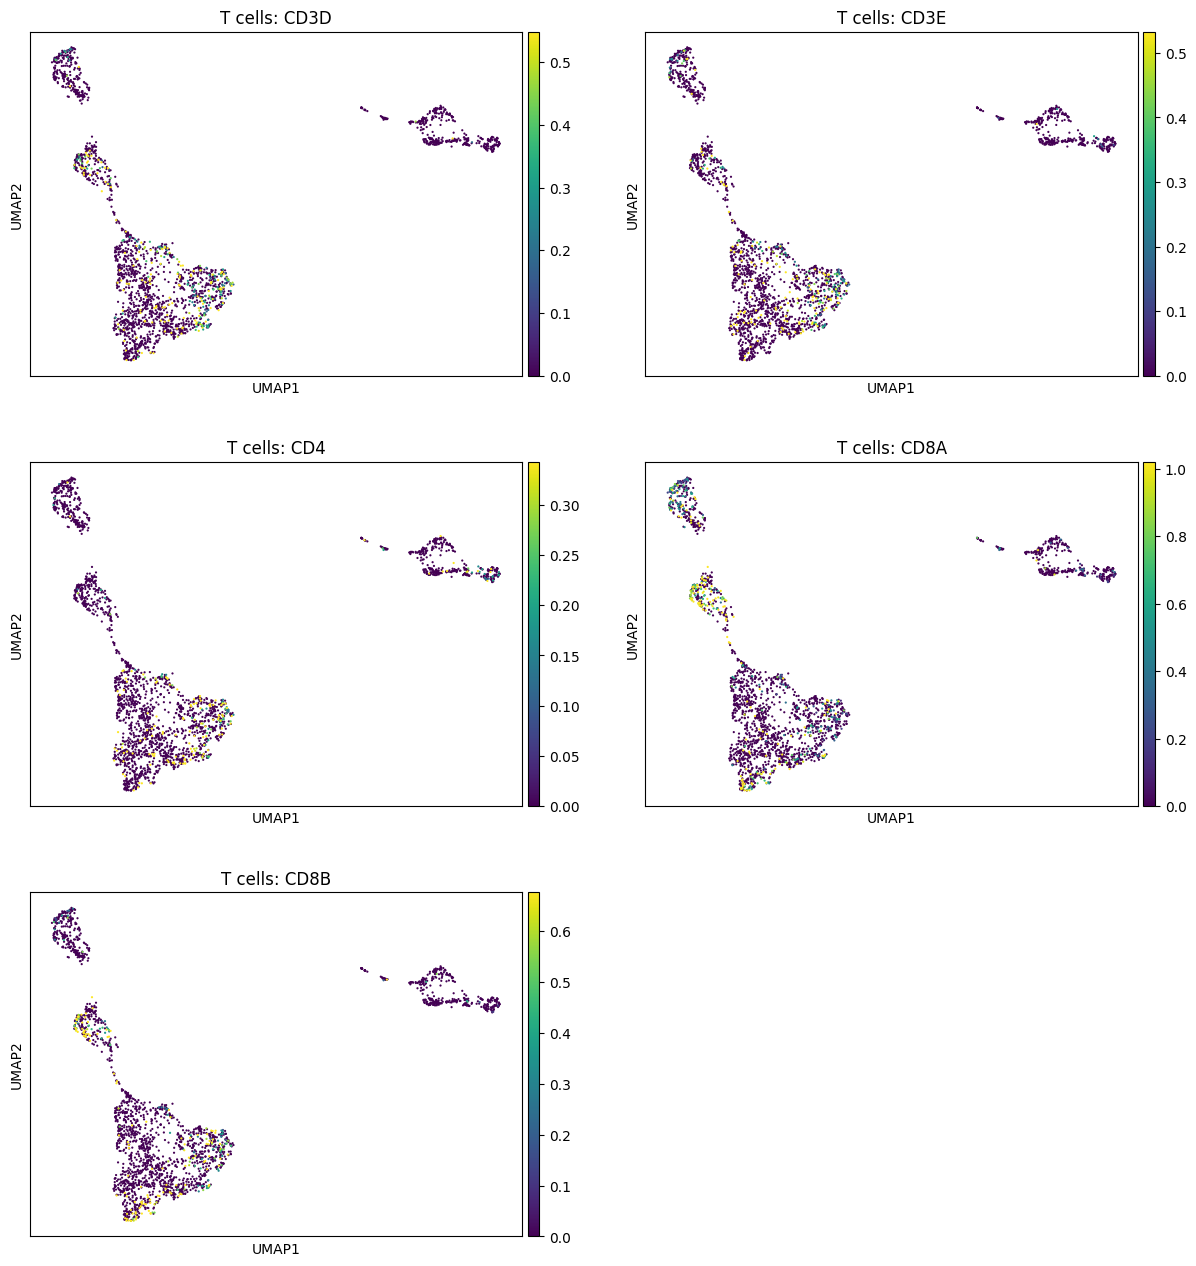

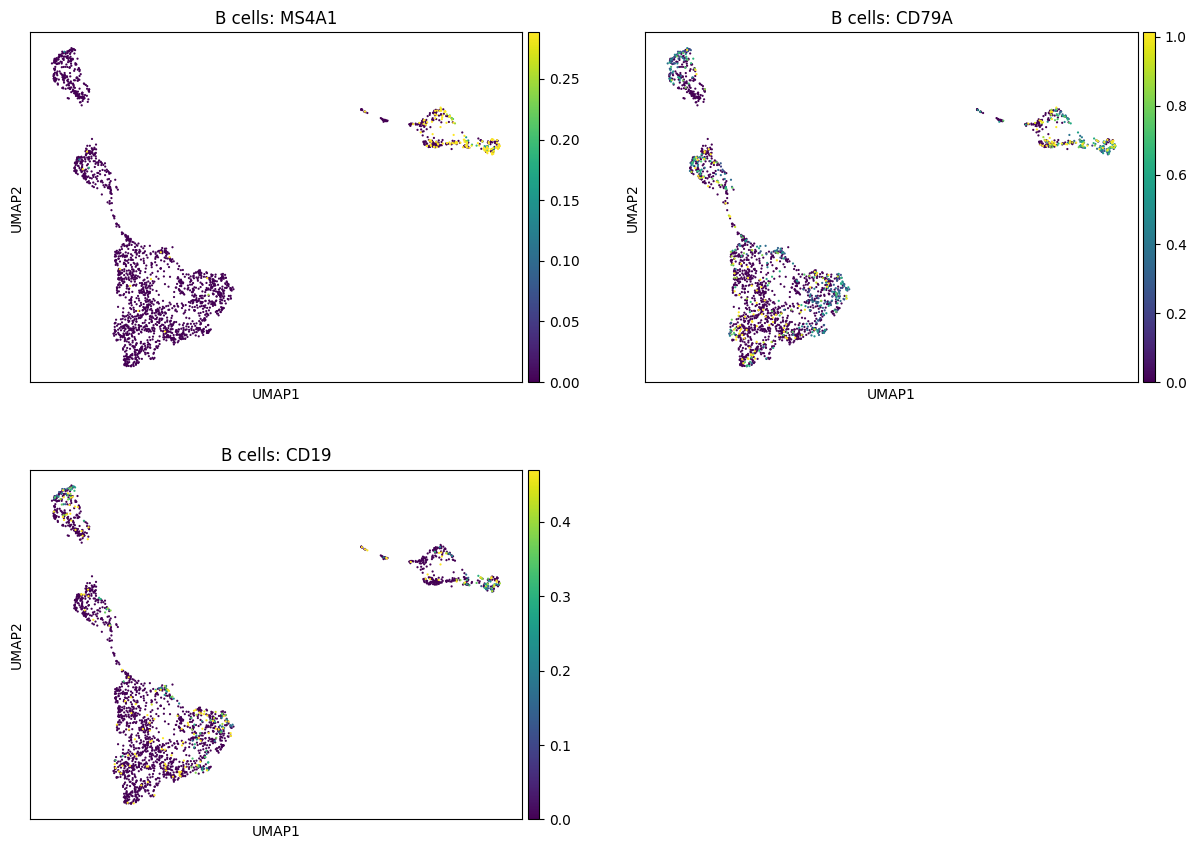

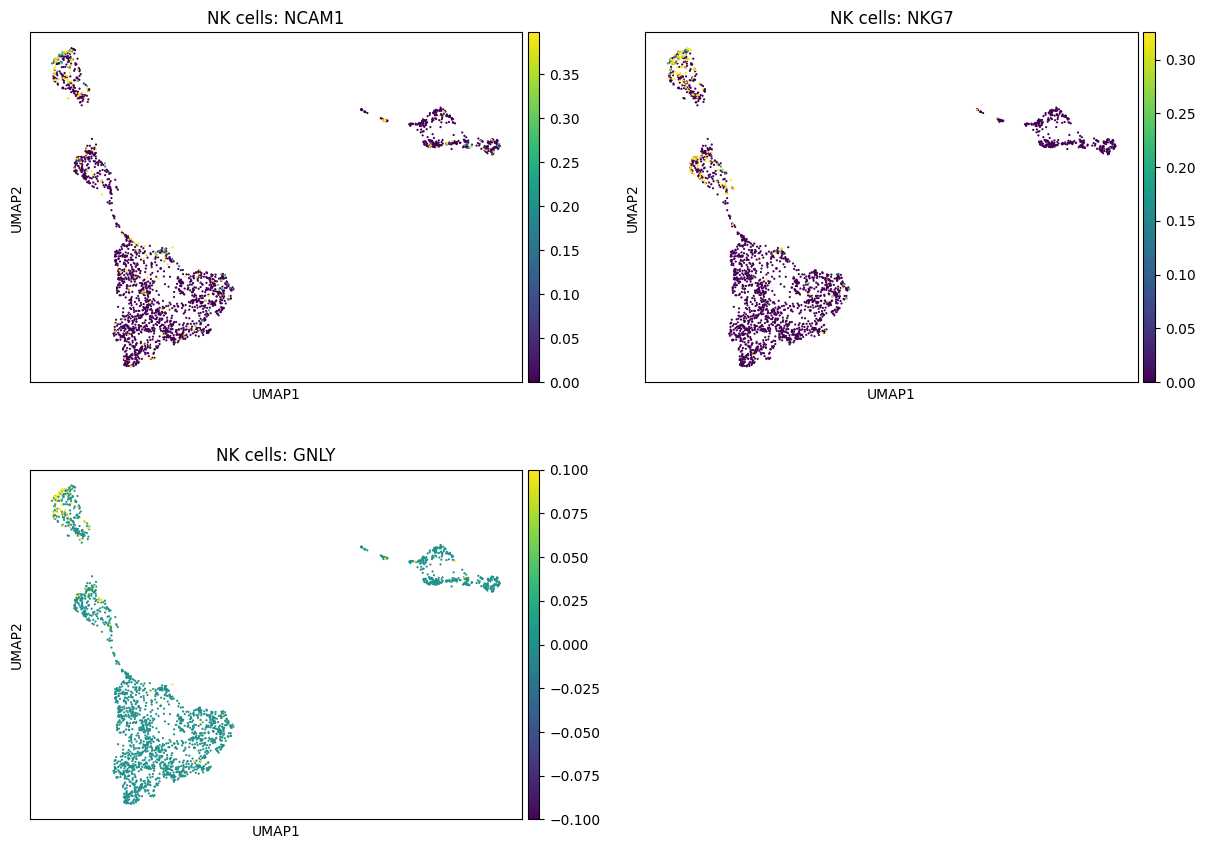

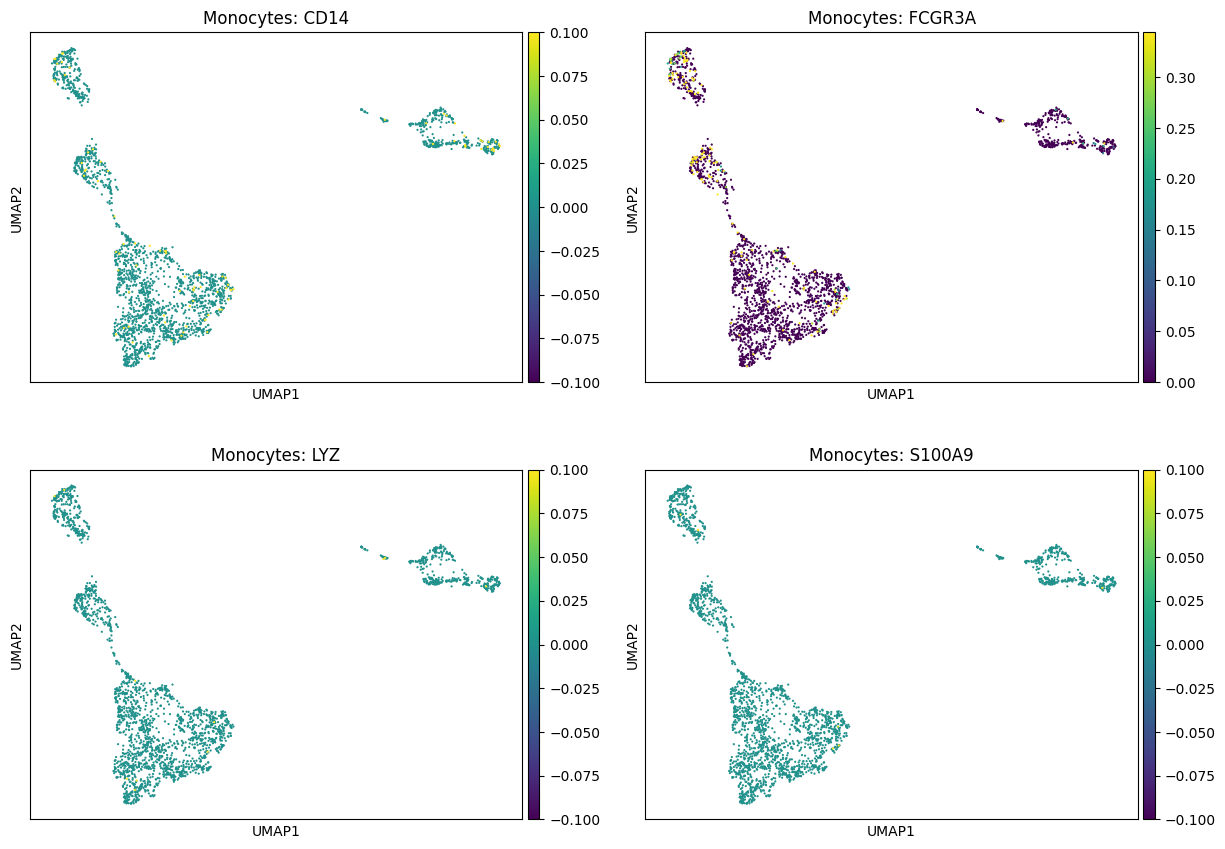

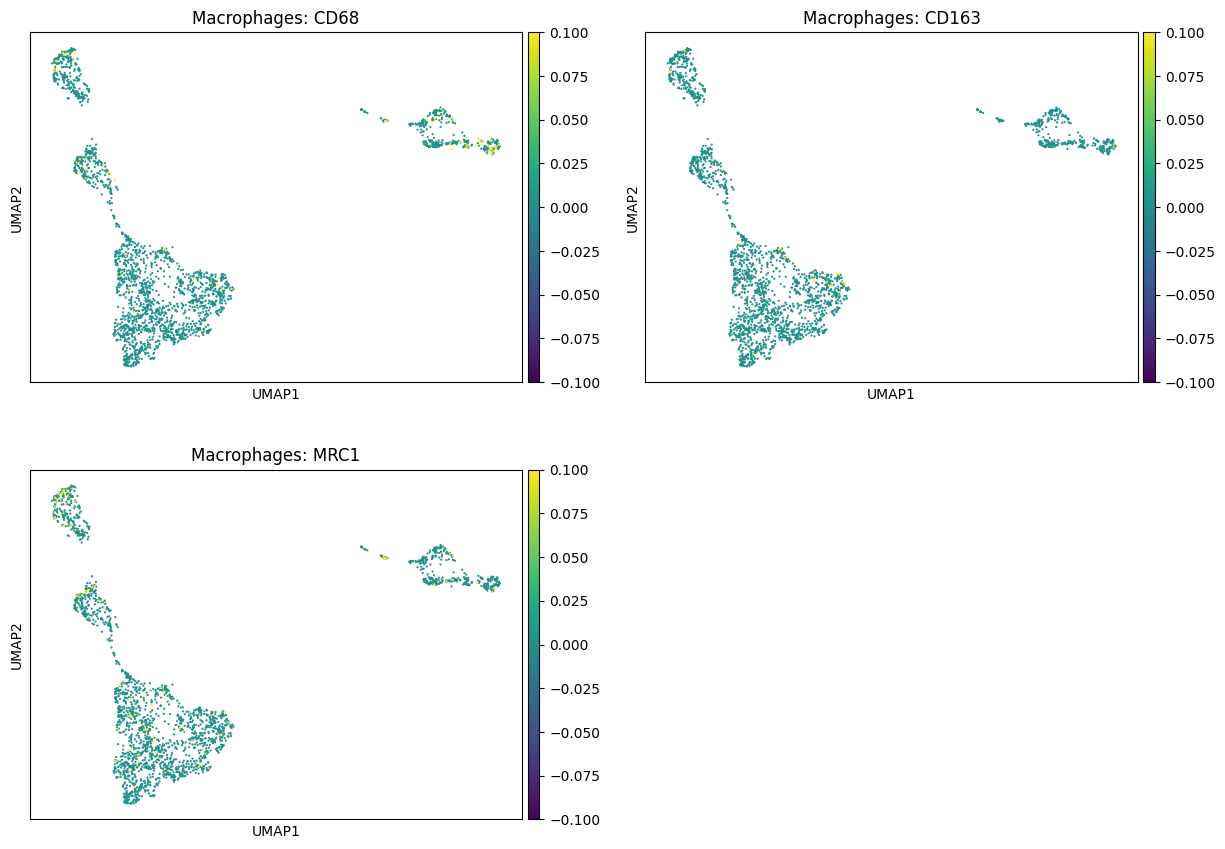

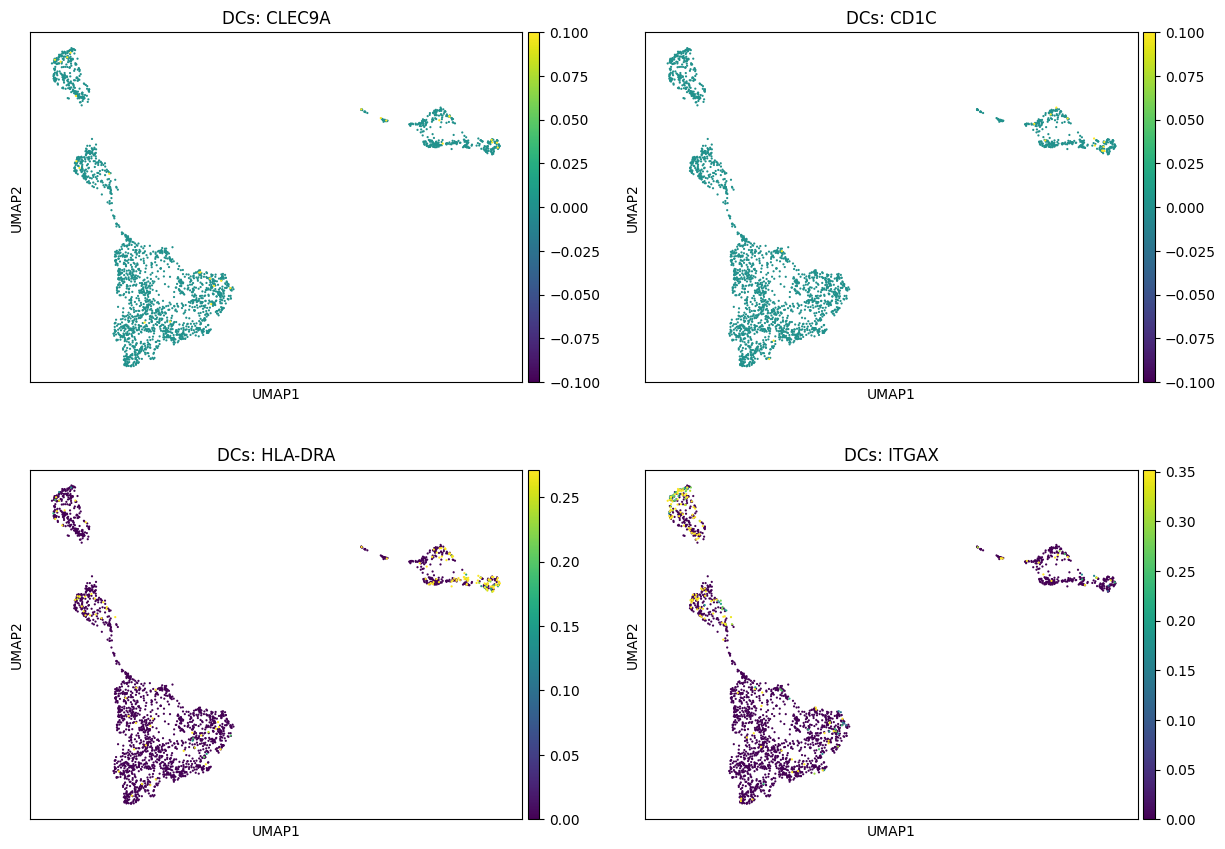

In [21]:
import matplotlib.pyplot as plt

# Define marker genes for each cell type
celltype_markers = {
    'T cells': ["CD3D", "CD3E", "CD4", "CD8A", "CD8B"],
    'B cells': ["MS4A1", "CD79A", "CD19"],
    'NK cells': ["NCAM1", "NKG7", "GNLY"],
    'Monocytes': ["CD14", "FCGR3A", "LYZ", "S100A9"],
    'Macrophages': ["CD68", "CD163", "MRC1"],
    'DCs': ["CLEC9A", "CD1C", "HLA-DRA", "ITGAX"]
}

# Plot UMAPs for each cell type's marker genes
for celltype, genes in celltype_markers.items():
    sc.pl.umap(
        gene_matrix, 
        color=genes, 
        ncols=2, 
        cmap='viridis',
        vmax='p95',
        size=10,
        title=[f"{celltype}: {gene}" for gene in genes],
        show=True
    )
plt.show()


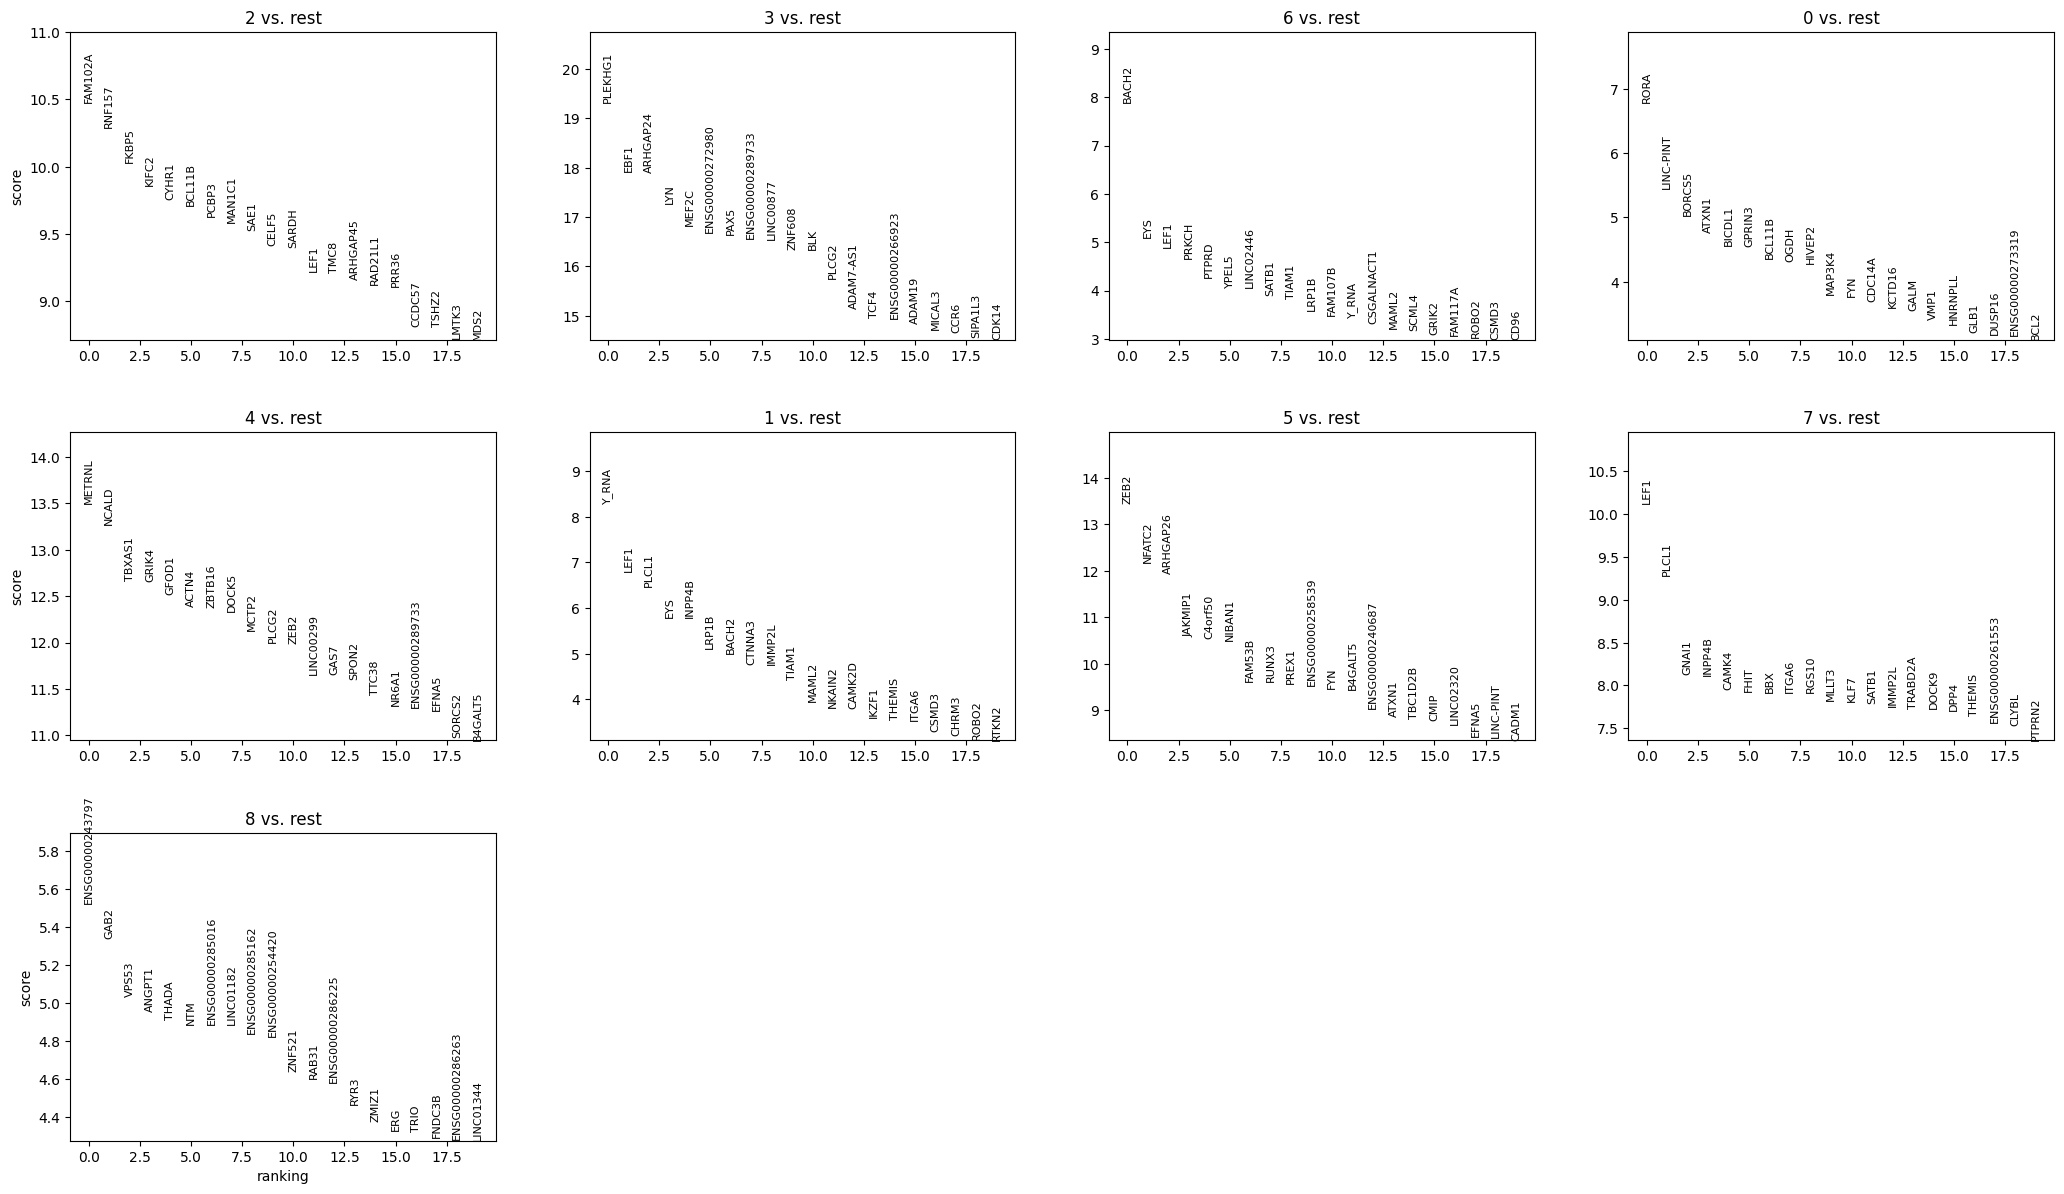

In [22]:
# Run differential expression analysis between clusters (e.g., 'leiden' clusters)
sc.tl.rank_genes_groups(gene_matrix, groupby='leiden', method='wilcoxon')

# Show the top marker genes for each cluster
sc.pl.rank_genes_groups(gene_matrix, n_genes=20, sharey=False)

In [25]:
##Not clear what the clusters are so I am going to do vague annotations
##Annotatig 
cluster_to_celltype = {
    "6": "Unsure",
    "0": "Unsure",
    "3": "B Cell",
    "1": "CD4 T cell",
    "2": "CD4 T cell",
    "4": "NK Cell",
    "5": "CD8 T cell",
    "7": "Unsure",
    "8": "B Cell"
    # Add more as needed
}

... storing 'celltype' as categorical


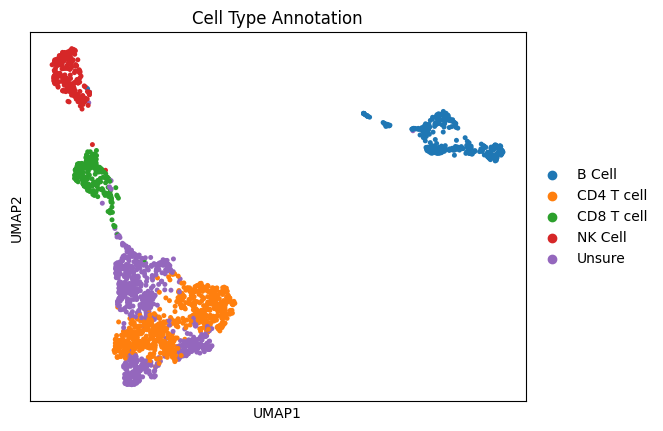

In [27]:
gene_matrix.obs['celltype'] = gene_matrix.obs['leiden'].map(cluster_to_celltype)
sc.pl.umap(gene_matrix, color=['celltype'], title="Cell Type Annotation")

In [ ]:
mgatk = process_and_integrate_variants("mgatkReference/final", gene_matrix)

Read coverage file:    pos                cell  coverage
0  637  GAAGTCTCAGATGGCA-1         2
1  638  GAAGTCTCAGATGGCA-1         2
2  639  GAAGTCTCAGATGGCA-1         2
3  640  GAAGTCTCAGATGGCA-1         2
4  641  GAAGTCTCAGATGGCA-1         2
identifying variants


/Users/nlt112/Library/CloudStorage/OneDrive-Personal/Documents/Work/Pickett/ATAC-Seq/snapATAC/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning:

invalid value encountered in divide

/Users/nlt112/Library/CloudStorage/OneDrive-Personal/Documents/Work/Pickett/ATAC-Seq/snapATAC/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning:

invalid value encountered in divide

/Users/nlt112/Library/CloudStorage/OneDrive-Personal/Documents/Work/Pickett/ATAC-Seq/snapATAC/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/Users/nlt112/Library/CloudStorage/OneDrive-Personal/Documents/Work/Pickett/ATAC-Seq/snapATAC/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



In [ ]:
# Cell metadata (cell barcodes and any associated info)
print(mgatk.obs.head())

# Variant metadata (summary statistics for each variant)
print(mgatk.var)

# Variant names (as "allele-pos-ref" strings)
print(mgatk.var.index)

                    n_fragment  frac_dup  frac_mito       tsse  \
AAACGAAAGAGTTTGA-1       12558  0.926326        0.0  20.295353   
AAACGAACACCTACCT-1        2127  0.888621        0.0  22.932023   
AAACGAAGTCAATACC-1        1199  0.824810        0.0  15.064935   
AAACTCGAGTACAGTA-1        1576  0.882502        0.0  18.181818   
AAACTCGCAGGCACAA-1        1602  0.866433        0.0  26.136364   

                    doublet_probability  doublet_score leiden    celltype  \
AAACGAAAGAGTTTGA-1             0.021910       0.093023      2  CD4 T cell   
AAACGAACACCTACCT-1             0.057260       0.013928      3      B Cell   
AAACGAAGTCAATACC-1             0.065694       0.008606      6      Unsure   
AAACTCGAGTACAGTA-1             0.069162       0.006689      0      Unsure   
AAACTCGCAGGCACAA-1             0.063978       0.009607      4     NK Cell   

                    count_A-10170-G  count_A-10197-G  ...  vaf_T-6925-C  \
AAACGAAAGAGTTTGA-1              NaN              NaN  ...       0

['vaf_G-3243-a']


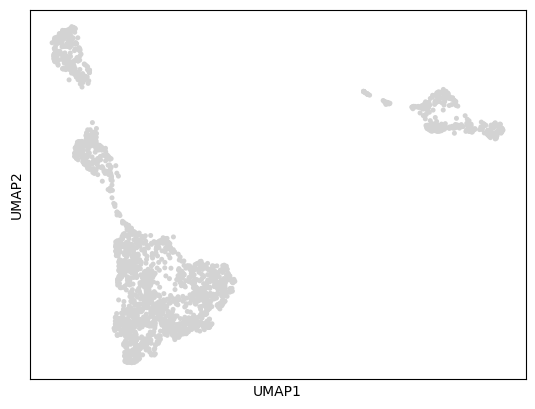

In [36]:
## Atttempting to plot m.3243A>G
# Find the variant name for 3243A>G
variant_name = "vaf_T-7028-C"
vaf_col = f"vaf_{variant_name}"
vaf_cols_3243 = [col for col in mgatk.obs.columns if "vaf_" in col and "3243" in col]
print(vaf_cols_3243)

sc.pl.umap(mgatk)

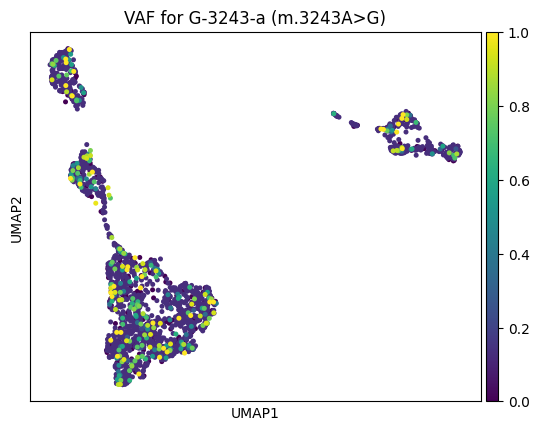

In [37]:
# Plot the selected variant (m.3243A>G) VAF on the UMAP
# This assumes the variant name is 'G-3243-a' and the VAF column is present in mgatk.obs
variant_name = "G-3243-a"
vaf_col = f"vaf_{variant_name}"
if vaf_col in mgatk.obs.columns:
    sc.pl.umap(mgatk, color=vaf_col, cmap="viridis", vmin=0, vmax=1, title=f"VAF for {variant_name} (m.3243A>G)")
else:
    print(f"Column {vaf_col} not found in mgatk.obs. Available VAF columns: {[col for col in mgatk.obs.columns if 'vaf_' in col]}")

In [ ]:
# Differential gene expression between high and low heteroplasmy using only mgatk


# Add heteroplasmy_group to mgatk.obs if not present
vaf_cols_3243 = [col for col in mgatk.obs.columns if "vaf_" in col and "3243" in col]
if vaf_cols_3243:
    vaf_col_3243 = vaf_cols_3243[0]
    mgatk.obs['heteroplasmy_group'] = mgatk.obs[vaf_col_3243].apply(lambda x: 'high' if x > 0.5 else 'low')
else:
    print("No VAF column found for m.3243A>G. Please check the variant naming.")
if 'heteroplasmy_group' in mgatk.obs.columns:
    sc.tl.rank_genes_groups(mgatk, groupby='heteroplasmy_group', method='wilcoxon')
    sc.pl.rank_genes_groups(mgatk, n_genes=20, sharey=False, title="Gene expression: High vs Low heteroplasmy (m.3243A>G)")
else:
    print("No heteroplasmy_group found in mgatk.obs. Please check the variant calling step.")